In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn import datasets
from mlxtend.data import loadlocal_mnist
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import numpy as np


In [23]:
!ls ../ats_comp_vision/mnist-dataset/

emnist-letters-mapping.txt	       emnist-letters-train.csv
emnist-letters-test.csv		       emnist-letters-train-images-idx3-ubyte
emnist-letters-test-images-idx3-ubyte  emnist-letters-train-labels-idx1-ubyte
emnist-letters-test-labels-idx1-ubyte


### Dataset Preparation

In [ ]:
raw_train_images, raw_train_labels = loadlocal_mnist(images_path='../ats_comp_vision/mnist-dataset/emnist-letters-train-images-idx3-ubyte',
                                            labels_path='../ats_comp_vision/mnist-dataset/emnist-letters-train-labels-idx1-ubyte')

In [ ]:
raw_train_images.shape, raw_train_labels.shape


((124800, 784), (124800,))

In [ ]:
train_images = []
train_labels = []

np.random.seed(42)

for i in range(1, 27):
    indices = np.where(train_labels == i)[0]
    selected_indices = np.random.choice(indices, size=100, replace=False)
    train_images.append(train_images[selected_indices])
    train_labels.append(train_labels[selected_indices])
    
# balanced_train_images.shape, balanced_train_labels.shape

train_images = np.vstack(train_images)
train_labels = np.hstack(train_labels)
train_images.shape, train_labels.shape

((2600, 784), (2600,))

Text(0.5, 1.0, 'Label: A')

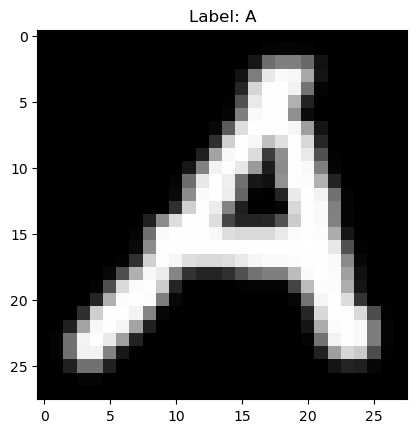

In [ ]:
plt.imshow(train_images[1].reshape(28, 28).T, cmap='gray')
plt.title(f"Label: {chr(train_labels[1] + 64)}")

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
labels_as_letters = [chr(label + 64) for label in unique]
unique

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=uint8)

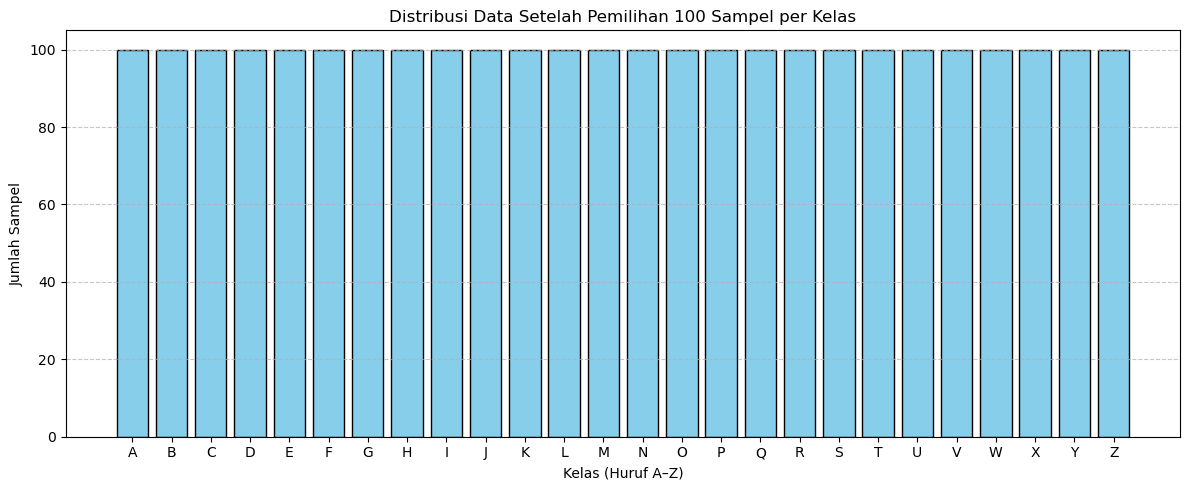

In [29]:
plt.figure(figsize=(12, 5))
plt.bar(labels_as_letters, counts, color='skyblue', edgecolor='black')
plt.title("Distribusi Data Setelah Pemilihan 100 Sampel per Kelas")
plt.xlabel("Kelas (Huruf A–Z)")
plt.ylabel("Jumlah Sampel")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
shuffle_idx = np.random.permutation(len(train_labels))
train_images = train_images[shuffle_idx]
balanced_train_labels = train_labels[shuffle_idx]

In [ ]:
feature, hog_image = hog(train_images[0].reshape(28,28), orientations=6, pixels_per_cell=(8, 8), cells_per_block=(2,2), visualize=True, block_norm='L2-Hys')


In [32]:
feature, hog_img = hog(train_images[0].reshape(28,28), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), visualize=True, block_norm='L2')


(144,)

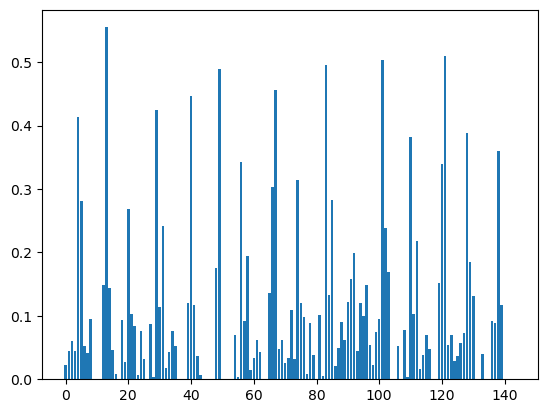

In [33]:
plt.bar(list(range(feature.shape[0])), feature)
feature.shape

In [34]:
n_dims = feature.shape[0]
n_dims

144

In [ ]:
n_samples=train_images.shape[0]
n_samples

2600

In [36]:
X_train, y_train = datasets.make_classification(n_samples, n_dims)
X_train.shape, y_train.shape

((2600, 144), (2600,))

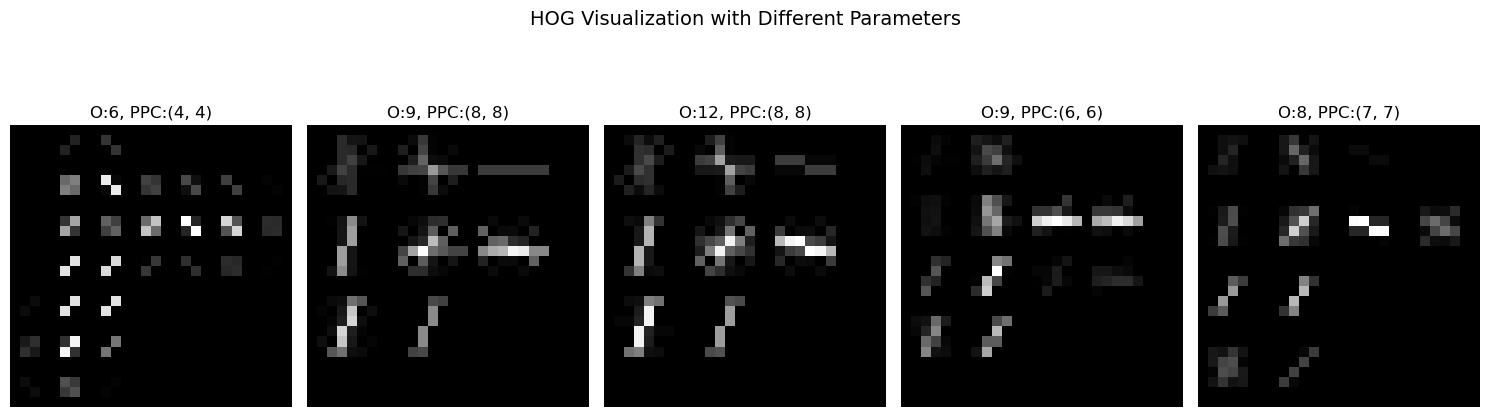

In [ ]:
from skimage.feature import hog
import matplotlib.pyplot as plt

# Example image
img = train_images[1].reshape(28, 28).T

# Different parameter sets to try
param_sets = [
    {"orientations": 6, "pixels_per_cell": (4, 4), "cells_per_block": (2, 2)},
    {"orientations": 9, "pixels_per_cell": (8, 8), "cells_per_block": (2, 2)},
    {"orientations": 12, "pixels_per_cell": (8, 8), "cells_per_block": (3, 3)},
    {"orientations": 9, "pixels_per_cell": (6, 6), "cells_per_block": (2, 2)},
    {"orientations": 8, "pixels_per_cell": (7, 7), "cells_per_block": (2, 2)},
]

plt.figure(figsize=(15, 5))

for i, params in enumerate(param_sets):
    features, hog_image = hog(
        img,
        visualize=True,
        block_norm='L2',
        **params
    )
    
    plt.subplot(1, len(param_sets), i + 1)
    plt.imshow(hog_image, cmap='gray')
    plt.title(f"O:{params['orientations']}, PPC:{params['pixels_per_cell']}")
    plt.axis('off')

plt.suptitle("HOG Visualization with Different Parameters", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
for i in range(n_samples):
    X_train[i], _ = hog(train_images[i].reshape(28, 28),orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), visualize=True, block_norm='L2')
    y_train[i] = balanced_train_labels[i]

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42,shuffle=False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((2080, 144), (2080,), (520, 144), (520,))

### Suppport vector machine

In [41]:
from sklearn.svm import SVC
clf = SVC()


### use gridsearch to find param

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report,confusion_matrix
import pandas as pd


scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

param_grid = {
    'C': [0.1,1,3.2, 5.0, 2.4, 10.0],
    'kernel': ['rbf', 'linear'],
    'gamma': ["scale", "auto"]
}
grid_search = GridSearchCV(clf, param_grid, scoring=scoring, cv=5, refit='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)


cv_results = pd.DataFrame(grid_search.cv_results_)
cv_metrics = cv_results[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']]
print("\n=== Hasil Evaluasi Training (Cross-Validation) ===")
print(cv_metrics.sort_values(by='mean_test_f1', ascending=False))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/marcel/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/marcel/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/marcel/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/marcel/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/marcel/.local/lib/python3.10/site-pa


=== Hasil Evaluasi Training (Cross-Validation) ===
                                               params  mean_test_accuracy  \
8       {'C': 3.2, 'gamma': 'scale', 'kernel': 'rbf'}            0.779808   
12      {'C': 5.0, 'gamma': 'scale', 'kernel': 'rbf'}            0.778846   
20     {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}            0.777885   
16      {'C': 2.4, 'gamma': 'scale', 'kernel': 'rbf'}            0.774038   
4         {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}            0.755769   
5      {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}            0.749519   
7       {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}            0.749519   
9    {'C': 3.2, 'gamma': 'scale', 'kernel': 'linear'}            0.747596   
11    {'C': 3.2, 'gamma': 'auto', 'kernel': 'linear'}            0.747596   
19    {'C': 2.4, 'gamma': 'auto', 'kernel': 'linear'}            0.746635   
17   {'C': 2.4, 'gamma': 'scale', 'kernel': 'linear'}            0.746635   
15    {'C': 5.0, 'gamma'

In [43]:
best_model = grid_search.best_estimator_
print("\n=== Parameter Terbaik ===")
print(grid_search.best_params_)


=== Parameter Terbaik ===
{'C': 3.2, 'gamma': 'scale', 'kernel': 'rbf'}


### use leave one out cross

In [44]:
from sklearn.model_selection import LeaveOneOut, cross_val_predict
loo = LeaveOneOut()
y_pred_loocv = cross_val_predict(best_model, X_train, y_train, cv=loo)
accuracy = accuracy_score(y_train, y_pred_loocv)
print("LOOCV Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision_score(y_train, y_pred_loocv, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(y_train, y_pred_loocv, average='weighted')))
print("F1 Score: {:.2f}%".format(f1_score(y_train, y_pred_loocv, average='weighted')))

cof_LOOCV = confusion_matrix(y_train, y_pred_loocv)


LOOCV Accuracy: 78.85%
Precision: 79.12%
Recall: 0.79%
F1 Score: 0.79%


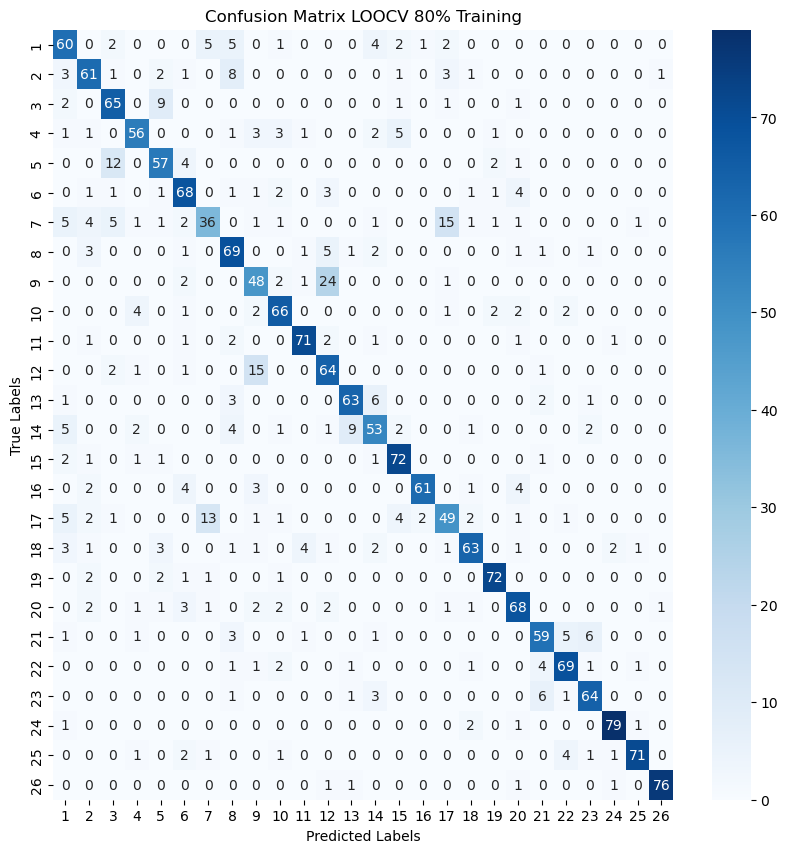

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cof_LOOCV, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix LOOCV 80% Training")
plt.show()


### use 20% from dataset

In [46]:
pred_test = best_model.predict(X_test) 
print("Test Accuracy: {:.2f}%".format(accuracy_score(y_test, pred_test) * 100))
print("Test Precision: {:.2f}".format(precision_score(y_test, pred_test, average='macro')))
print("Test Recall: {:.2f}".format(recall_score(y_test, pred_test, average='weighted')))
print("Test F1 Score: {:.2f}".format(f1_score(y_test, pred_test, average='weighted')))
conf_mat = confusion_matrix(y_test, pred_test)

Test Accuracy: 79.23%
Test Precision: 0.80
Test Recall: 0.79
Test F1 Score: 0.79


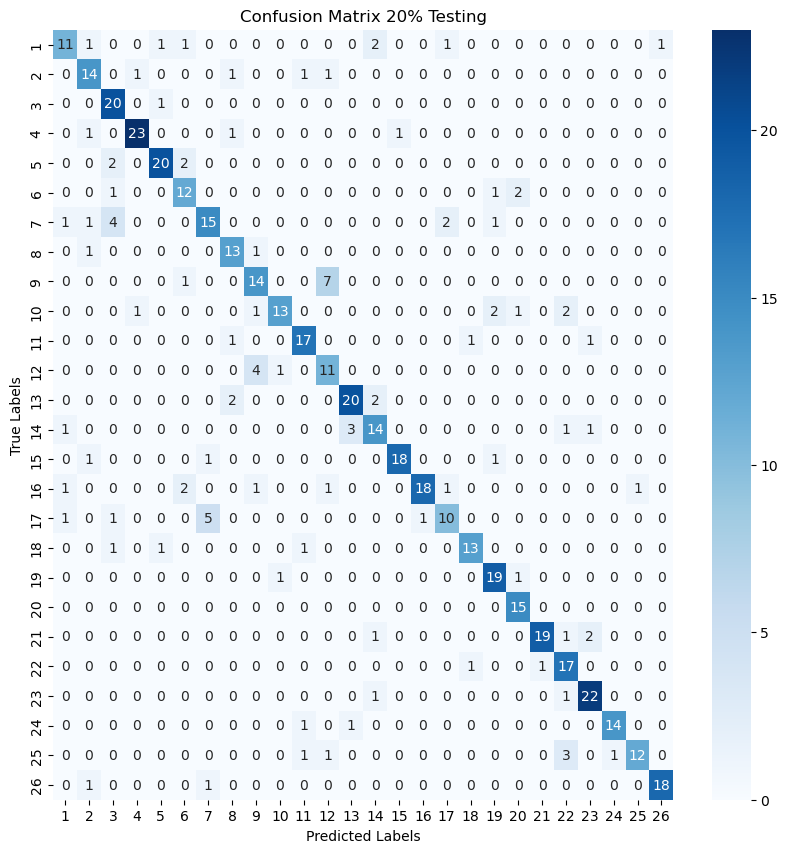

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix 20% Testing")
plt.show()

### testing model

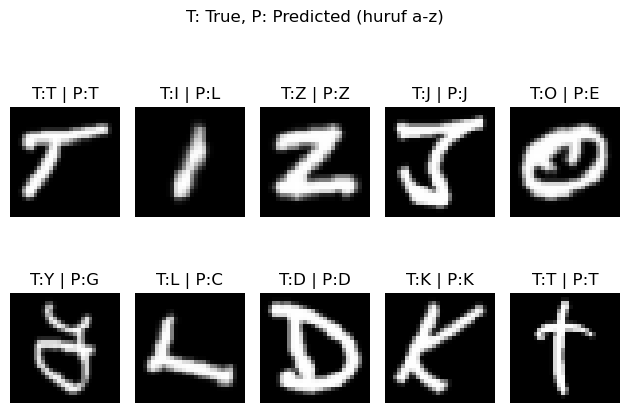

In [ ]:
import matplotlib.pyplot as plt
import random
indices = random.sample(range(len(X_train)), 10)
for i, idx in enumerate(indices):
    img =  train_images[idx].reshape(28, 28).T
    # img = X_test[i]
    true_label = y_train[idx] 
    pred_label = y_pred_loocv[idx] 

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{chr(true_label + 64)} | P:{chr(pred_label + 64)}") 
    plt.axis('off')
plt.suptitle("T: True, P: Predicted (huruf a-z)")
plt.tight_layout()
plt.show()

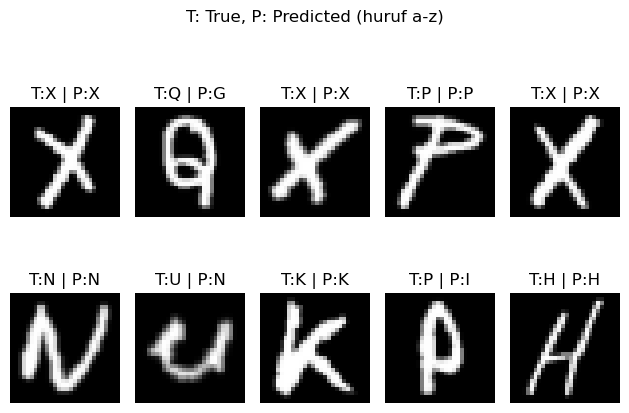

In [ ]:
indices = random.sample(range(len(X_test)), 10)

for i, idx in enumerate(indices):
    img =  train_images[idx+2080].reshape(28, 28).T
    # img = X_test[i]
    true_label = y_test[idx] 
    pred_label = pred_test[idx] 

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{chr(true_label + 64)} | P:{chr(pred_label + 64)}") 
    plt.axis('off')

plt.suptitle("T: True, P: Predicted (huruf a-z)")
plt.tight_layout()
plt.show()